In [ ]:
#import libaraies and dataset:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the preprocessed dataset
df = pd.read_csv("preprocessed_data.csv")

In [ ]:
# Check for GPU availability and configure accordingly
try:
    import cupy as cp
    GPU_AVAILABLE = True
    print("GPU detected - using GPU acceleration")
except:
    GPU_AVAILABLE = False
    print("No GPU detected - using CPU only")

# Try to enable GPU-optimized algorithms where available
if GPU_AVAILABLE:
    try:
        from cuml.ensemble import RandomForestClassifier as cuRF
        from cuml.svm import SVC as cuSVC
        CUML_AVAILABLE = True
        print("cuML detected - using GPU-accelerated algorithms")
    except:
        CUML_AVAILABLE = False
        print("cuML not available - using scikit-learn algorithms")
else:
    CUML_AVAILABLE = False

No GPU detected - using CPU only


In [ ]:
# Separate train and test sets
train_df = df[df['Set'] == 'Train'].drop('Set', axis=1)
test_df = df[df['Set'] == 'Test'].drop('Set', axis=1)

In [ ]:
# Separate features and target
X_train = train_df.drop('Revenue', axis=1)
y_train = train_df['Revenue']
X_test = test_df.drop('Revenue', axis=1)
y_test = test_df['Revenue']

In [ ]:
# Define models with GPU support where available
models = {
    'XGBoost': {
        'model': XGBClassifier(
            random_state=42, 
            eval_metric='logloss',
            tree_method='gpu_hist' if GPU_AVAILABLE else 'auto',
            gpu_id=0 if GPU_AVAILABLE else -1,
            verbosity=0  # Reduce output verbosity
        ),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 4, 5],
            'classifier__learning_rate': [0.05, 0.01],
            'classifier__subsample': [0.8, 0.9],
            'classifier__colsample_bytree': [0.8, 0.9],
            'classifier__gamma': [0, 0.1, 0.2]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(
            random_state=42, 
            class_weight='balanced',
            device='gpu' if GPU_AVAILABLE else 'cpu',
            verbose=-1  # Silence output
        ),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.05, 0.01],
            'classifier__num_leaves': [31, 50, 70],
            'classifier__subsample': [0.8, 0.9],
            'classifier__colsample_bytree': [0.8, 0.9]
        }
    }
}

# Add GPU-accelerated models if available
if CUML_AVAILABLE:
    models['RandomForest_GPU'] = {
        'model': cuRF(
            random_state=42,
            class_weight='balanced'
        ),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [5, 10, 15],
            'classifier__max_features': [0.5, 0.7, 0.9]
        }
    }
    
    models['SVM_GPU'] = {
        'model': cuSVC(
            random_state=42,
            probability=True
        ),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': [0, 1],  # 0=linear, 1=rbf in cuML
            'classifier__gamma': [0.1,'auto', 1, 10]
        }
    }
else:
    # Add CPU versions if GPU not available
    models['RandomForest'] = {
        'model': RandomForestClassifier(
            random_state=42, 
            class_weight='balanced',
            n_jobs=-1  # Use all cores
        ),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [5, 7, 10,None],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2],
            'classifier__max_features': [0.5, 0.7, 0.9],
            'classifier__bootstrap': [True, False]
            
        }
    }
    
    models['GradientBoosting'] = {
        'model': GradientBoostingClassifier(
            random_state=42,
            verbose=0  # Silence output
        ),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.05, 0.01],
            'classifier__max_depth': [3, 4, 5],
            'classifier__subsample': [0.8, 0.9],
            'classifier__min_samples_split': [2, 5, 10]
        }
    }

# For even faster training, we can use a subset of data for hyperparameter tuning
# This is optional but can significantly speed up the process
use_subset_for_tuning = True
tuning_subset_size = 0.5  # Use 50% of data for tuning

if use_subset_for_tuning:
    from sklearn.utils import resample
    X_tune, _, y_tune, _ = train_test_split(
        X_train, y_train, 
        train_size=tuning_subset_size, 
        random_state=42, 
        stratify=y_train
    )
    print(f"Using {tuning_subset_size*100}% of data ({len(X_tune)} samples) for hyperparameter tuning")
else:
    X_tune, y_tune = X_train, y_train

# Perform hyperparameter tuning and evaluation
results = {}
best_models = {}

for name, model_info in models.items():
    print(f"\nTraining and tuning {name}...")
    
    # Create pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('classifier', model_info['model'])
    ])
    
    # Use Bayesian Optimization for more efficient hyperparameter search
    # If scikit-optimize is available
    try:
        from skopt import BayesSearchCV
        from skopt.space import Real, Categorical, Integer
        
        # Convert parameter grid to skopt space
        param_space = {}
        for param, values in model_info['params'].items():
            if all(isinstance(v, (int, np.integer)) for v in values):
                param_space[param] = Integer(min(values), max(values))
            elif all(isinstance(v, (float, np.floating)) for v in values):
                param_space[param] = Real(min(values), max(values))
            else:
                param_space[param] = Categorical(values)
        
        search = BayesSearchCV(
            pipeline,
            param_space,
            n_iter=10,  # Fewer iterations needed with Bayesian optimization
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
            scoring='f1',
            n_jobs=1 if CUML_AVAILABLE else -1,  # cuML doesn't support n_jobs > 1
            random_state=42,
            verbose=0
        )
        method = "Bayesian Optimization"
        
    except ImportError:
        # Fall back to RandomizedSearchCV if scikit-optimize not available
        search = RandomizedSearchCV(
            pipeline, 
            model_info['params'], 
            n_iter=10,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
            scoring='f1',
            n_jobs=1 if CUML_AVAILABLE else -1,
            random_state=42,
            verbose=0
        )
        method = "Randomized Search"
    
    print(f"Using {method} for hyperparameter tuning")
    
    # Fit the model
    search.fit(X_tune, y_tune)
    
    # Get the best model
    best_model = search.best_estimator_
    best_models[name] = best_model
    
    # Make predictions on full test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Store results
    results[name] = {
        'best_params': search.best_params_,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'cv_score': search.best_score_
    }
    
    print(f"Best parameters: {search.best_params_}")
    print(f"F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")


Using 50.0% of data (8237 samples) for hyperparameter tuning

Training and tuning XGBoost...
Using Randomized Search for hyperparameter tuning
Best parameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0, 'classifier__colsample_bytree': 0.9}
F1 Score: 0.8864, ROC AUC: 0.9515

Training and tuning LightGBM...
Using Randomized Search for hyperparameter tuning
Best parameters: {'classifier__subsample': 0.9, 'classifier__num_leaves': 31, 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.8}
F1 Score: 0.8827, ROC AUC: 0.9506

Training and tuning RandomForest...
Using Randomized Search for hyperparameter tuning
Best parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 0.7, 'classifier__max_depth': None, 'classifier__boot

We are using a subset of data for hyperparameter tuning to speed up the process. Hyperparameter tuning with cross-validation can be computationally expensive, especially with large datasets and multiple models. By using a representative subset, we can quickly narrow down the best hyperparameters and then train the final model on the full dataset.

However, note that in the code above, we are only using a subset for hyperparameter tuning (the X_tune and y_tune). Then, after we find the best hyperparameters, we retrain the best model on the entire training set (X_train, y_train). This is a common practice to save time while still leveraging the full dataset for the final model.

In [ ]:


# Create a results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'cv_score']]
results_df = results_df.sort_values('f1', ascending=False)

print("\nModel Comparison:")
print(results_df)




Model Comparison:
                  accuracy precision    recall        f1   roc_auc  cv_score
XGBoost           0.885409  0.878759  0.894123  0.886375  0.951542  0.887838
RandomForest      0.884195  0.876308  0.894609  0.885364  0.953021  0.888953
GradientBoosting  0.882981  0.879634  0.887324  0.883462  0.950272  0.885522
LightGBM          0.881767  0.875358  0.890238  0.882735  0.950571  0.887666



Best model: XGBoost

Detailed evaluation of XGBoost:
Accuracy: 0.8854
Precision: 0.8788
Recall: 0.8941
F1 Score: 0.8864
ROC AUC: 0.9515

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2060
           1       0.88      0.89      0.89      2059

    accuracy                           0.89      4119
   macro avg       0.89      0.89      0.89      4119
weighted avg       0.89      0.89      0.89      4119



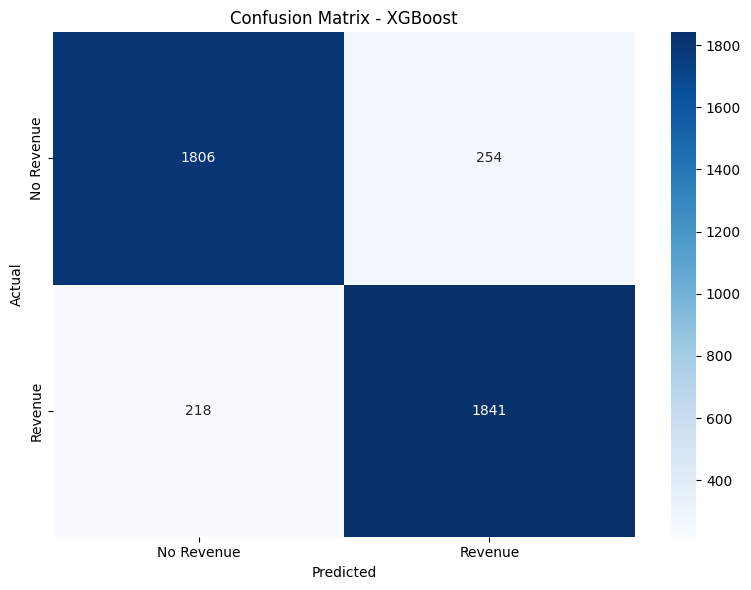

In [ ]:
# Identify the best model based on F1 score
best_model_name = results_df.index[0]
best_model = best_models[best_model_name]
print(f"\nBest model: {best_model_name}")

# Detailed evaluation of the best model
print(f"\nDetailed evaluation of {best_model_name}:")
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Revenue', 'Revenue'],
            yticklabels=['No Revenue', 'Revenue'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

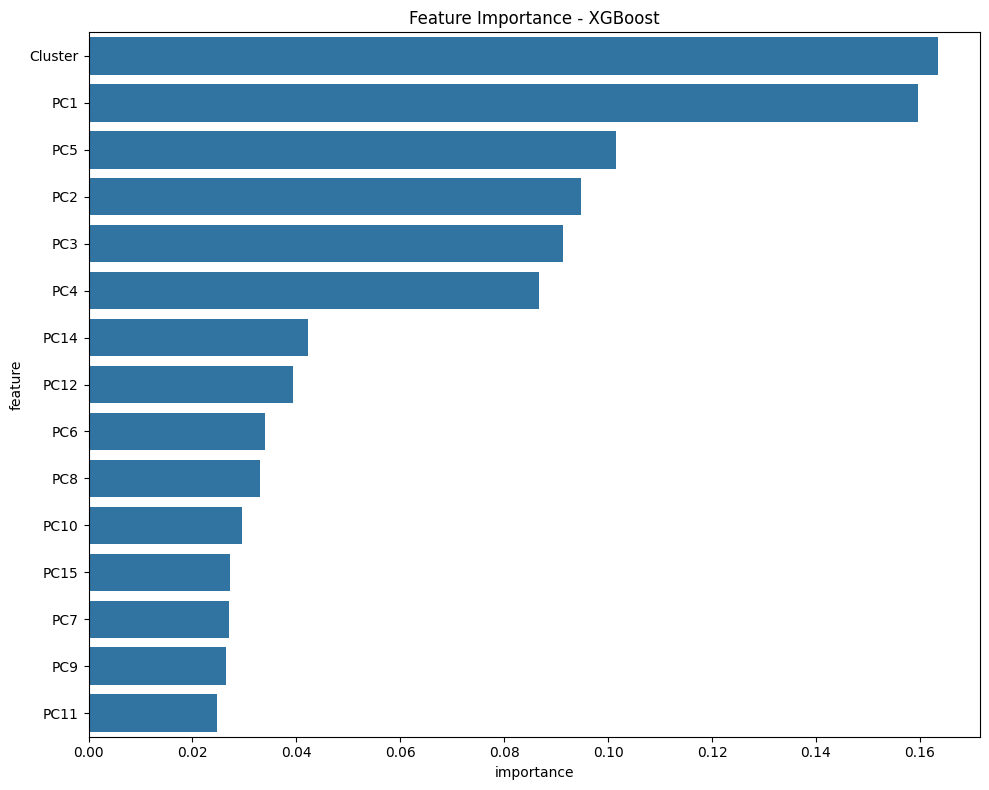

In [ ]:
# Feature importance for tree-based models
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.named_steps['classifier'].feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

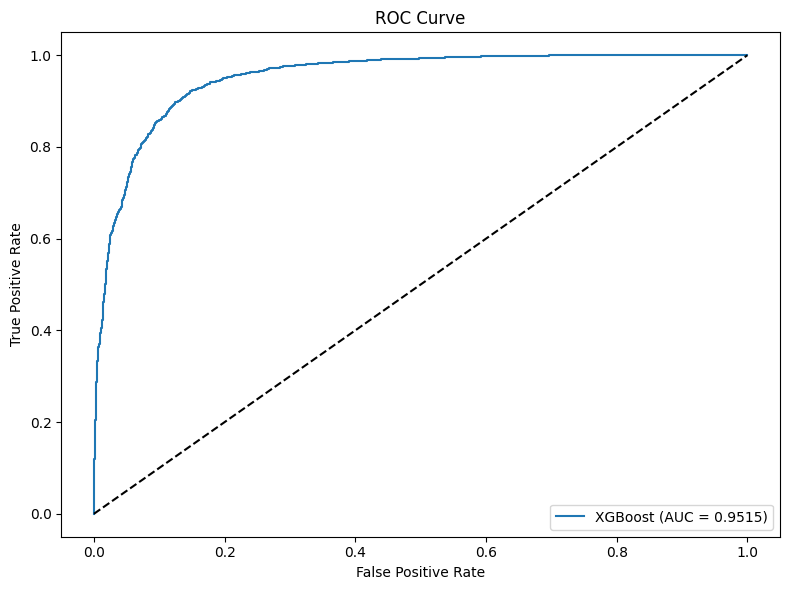

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc_score(y_test, y_prob):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()


In [ ]:
# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print("\nBest model saved as 'best_model.pkl'")


Best model saved as 'best_model.pkl'


In [ ]:
# Check for overfitting by comparing train and test performance
train_pred = best_model.predict(X_train)
train_prob = best_model.predict_proba(X_train)[:, 1]

print("\nOverfitting Check:")
print(f"Train F1 Score: {f1_score(y_train, train_pred):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Train ROC AUC: {roc_auc_score(y_train, train_prob):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")


Overfitting Check:
Train F1 Score: 0.9202
Test F1 Score: 0.8864
Train ROC AUC: 0.9725
Test ROC AUC: 0.9515
